# El dataset se puede descargar de: https://www.kaggle.com/datasets/imsparsh/musicnet-dataset

Una vez descargado se debe poner en la carpeta /kaggle/input/musicnet-dataset todo el contenido de la descarga

_______________________________

Para la ejecucipn de este cuaderno se deben instalar las siguientes librerias (en las versiones establecidas), tal como se muestra a continuacion

# importamos las librerias a usar

In [21]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import IPython.display as ipd

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

import librosa
import librosa.display

import os

In [22]:
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    for id, filename in enumerate(filenames):
        print(os.path.join(dirname, filename))
        if id > 10:
            break
            
"""

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    print(dirname)\n    for id, filename in enumerate(filenames):\n        print(os.path.join(dirname, filename))\n        if id > 10:\n            break\n            \n"

In [28]:
class Wav:
    
    path_wav = "/kaggle/input/musicnet-dataset/musicnet/musicnet/train_data/"
    path_csv = "/kaggle/input/musicnet-dataset/musicnet/musicnet/train_labels/"
    
    def __init__(self):
        self.file_wav=os.listdir(self.path_wav)
    
    def cargar(self, i:int, draw=False):
        audio_usar = self.path_wav + self.file_wav[i]
        self.data, self.sampling_rate = librosa.load(audio_usar)
        
        self.audio_usar = audio_usar.split("/")[-1]
        self.label_usar = self.path_csv + self.audio_usar.split(".")[0] + ".csv"
        self.labels = pd.read_csv(self.label_usar)
        
        if draw:
            librosa.display.waveplot(self.data, sr=self.sampling_rate)
            plt.title("normal")
            plt.show()
        
        return self.data, self.sampling_rate
    
    def get_data_train(self):
        data = {
            "name_audio": self.audio_usar,
            "numpy_audio": self.data,
            "name_label": self.label_usar.split("/")[-1],
            "pandas_label": self.labels
        }
        return data
    
    def convertir_fourier(self, draw=False):
        # stft es una forma abreviada de transformada de Fourier de tiempo corto
        fourier = librosa.stft(self.data) 
        
        s = np.abs(fourier**2) # Obtener la magnitud de stft
        
        # Chroma incluye el proceso de extracción de características
        # Chroma es un vector de 12 elementos que mide la energía del tono del sonido.
        chroma = librosa.feature.chroma_stft(S=s, sr=self.sampling_rate) 
        chroma = np.cumsum(chroma) 
        
        if draw:
            x = np.linspace(-chroma, chroma)
            plt.plot(x, np.sin(x))
            plt.xlabel('Angle [rad]')
            plt.ylabel('sin(x)')
            plt.axis('tight')
            plt.show()
    
    def extraer_espectograma(self):
        self.S = librosa.feature.melspectrogram(y=self.data, sr=self.sampling_rate, n_mels=128,fmax=10000)
        return self.S
        
    def convertir_db(self, draw=False):
        #Convert a power spectrogram (amplitude squared) to decibel (dB) units
        self.S_dB = librosa.power_to_db(self.S, ref=np.max)
        
        if draw:
            librosa.display.specshow(self.S_dB, x_axis='time',y_axis='mel', sr=self.sampling_rate,fmax=10000, fmin=200)
            self.__prepare_show("DB")
            plt.show()
            
        return self.S_dB
    
    def convertir_db_2(self, draw=False):        
        C = np.abs(librosa.cqt(y=self.data, sr=self.sampling_rate, bins_per_octave=12*3, n_bins=7*12*3))
        amplitude = librosa.amplitude_to_db(C, ref=np.max)
        
        chroma_orig = librosa.feature.chroma_cqt(y=self.data, sr=self.sampling_rate)
        
        img1 = librosa.display.specshow(chroma_orig,
                                y_axis='cqt_note', x_axis='time', bins_per_octave=12*3,
                                ax=ax[0])
        
        if draw:
            pass
    
    def __prepare_show(self, title):
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        



In [29]:
wav = Wav()

<Figure size 1500x500 with 0 Axes>

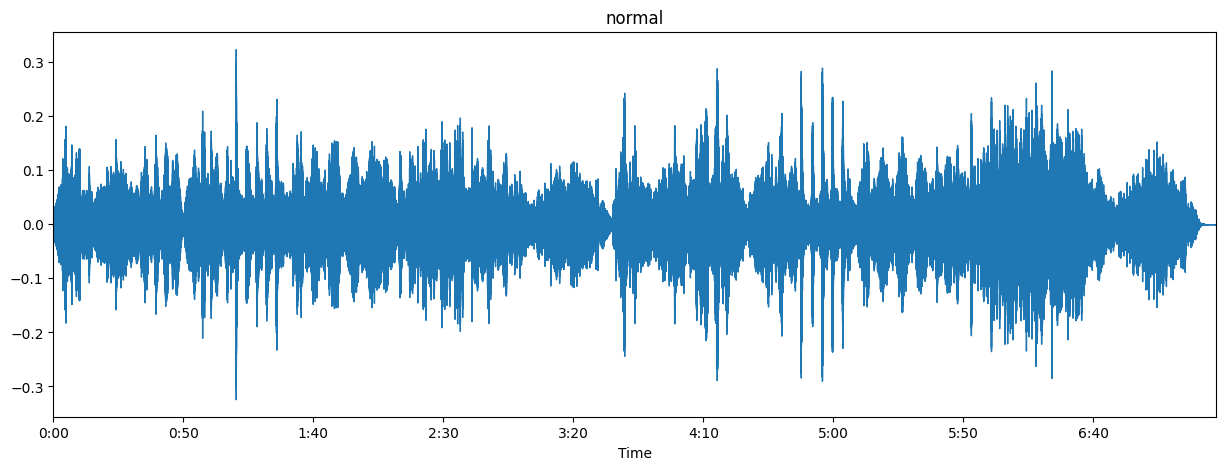

In [30]:
data, _ = wav.cargar(0, True)

In [31]:
wav.get_data_train()

{'name_audio': '1727.wav',
 'numpy_audio': array([-1.7038242e-07,  1.6850117e-07, -1.5837151e-07, ...,
         2.2710454e-08, -3.4247947e-08,  4.1863355e-08], dtype=float32),
 'name_label': '1727.csv',
 'pandas_label':       start_time  end_time  instrument  note  start_beat  end_beat  \
 0           9182     90078          43    53       4.000     1.500   
 1           9182     33758          42    65       4.000     0.500   
 2           9182     62430           1    69       4.000     1.000   
 3           9182    202206          44    41       4.000     3.500   
 4           9182     62430           1    81       4.000     1.000   
 ...          ...       ...         ...   ...         ...       ...   
 6575    19196894  19421150          44    29     365.000     3.000   
 6576    19226590  19233758           1    60     365.375     0.125   
 6577    19226590  19233758           1    48     365.375     0.125   
 6578    19233758  19421150           1    65     365.500     2.500   


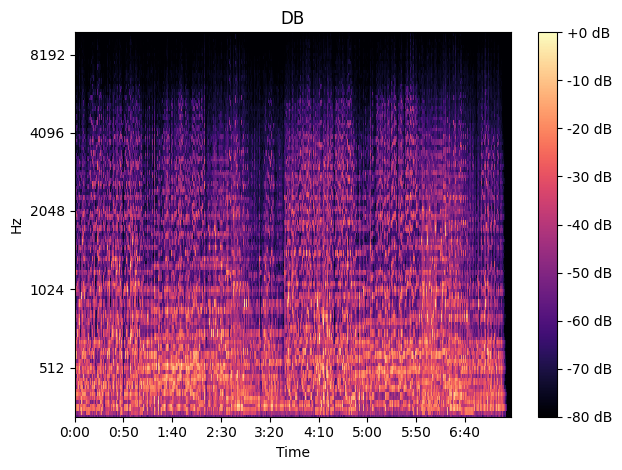

In [32]:
wav.extraer_espectograma()
db= wav.convertir_db(True)

In [31]:
#wav.convertir_fourier(True) # aun no funciona

In [34]:
idx = tuple([slice(None), slice(*list(librosa.time_to_frames([45, 60])))])
idx

(slice(None, None, None), slice(1937, 2583, None))

In [35]:
import scipy.io.wavfile as wav
from python_speech_features import mfcc

In [36]:
(rate, sig) = wav.read("/kaggle/input/musicnet-dataset/musicnet/musicnet/train_data/1727.wav")

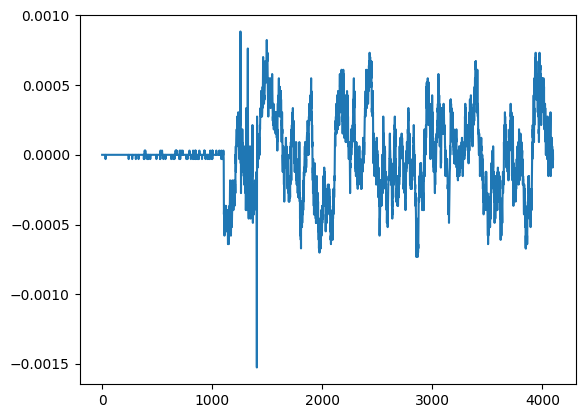

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 4096, 4096)
plt.figure('original signal')
plt.plot(x,sig[0:4096])
plt.show()

In [38]:
from python_speech_features import logfbank
from python_speech_features import delta


In [39]:
d_mfcc_feat = delta(mfcc_feat, 2)
dd_mfcc_feat = delta(d_mfcc_feat,2)

In [40]:
mfcc_feat = mfcc(sig, rate)
mfcc_colunm1 = mfcc_feat[:,0]
mfcc_row1 = mfcc_feat[0]
d_mfcc_feat_column1 = d_mfcc_feat[0]
dd_mfcc_feat_column1 = dd_mfcc_feat[0]

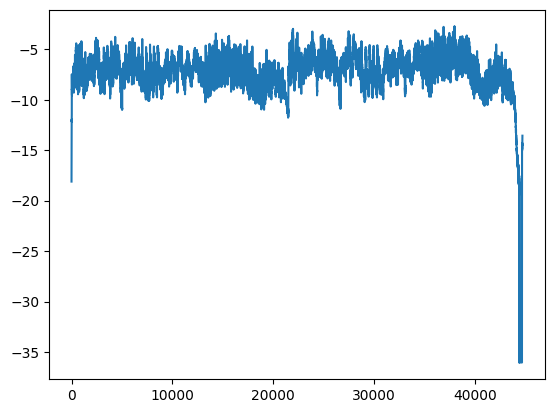

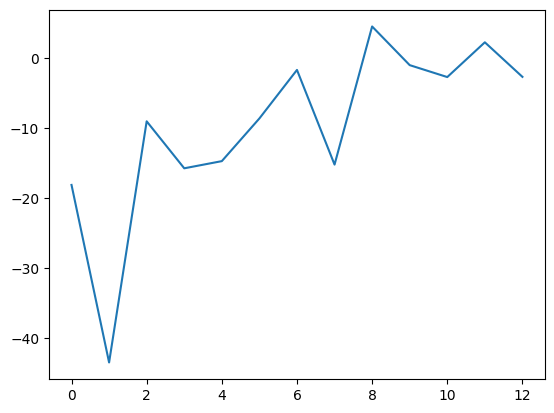

In [41]:
plt.figure()
plt.plot(mfcc_colunm1)
plt.show()

plt.figure()
plt.plot(mfcc_row1)
plt.show()

# Bibliografia usada